Device = cpu
=== Loading datasets ===


/scratch/22626391/ipykernel_770737/3722962549.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location="cpu"))


 SL : models/pooled_eegnet_best.pth
 Hybrid : feature_bank = (220, 992)
 SL : models/pooled_eegnet_best.pth
 Hybrid : feature_bank = (576, 992)
 SL : models/pooled_eegnet_best.pth
 Hybrid : feature_bank = (220, 992)
 SL : models/pooled_eegnet_best.pth
 Hybrid : feature_bank = (576, 992)
=== Env Build Completed (16D) ===
===== Training DQN =====
[DQN Ep 20] VAL=18.0% | Test-ID=26.0% | Test-OOD=24.0%
[DQN Ep 40] VAL=78.0% | Test-ID=56.0% | Test-OOD=80.0%
[DQN Ep 60] VAL=98.0% | Test-ID=100.0% | Test-OOD=100.0%
[DQN Ep 80] VAL=90.0% | Test-ID=80.0% | Test-OOD=82.0%
[DQN Ep 100] VAL=58.0% | Test-ID=82.0% | Test-OOD=64.0%
[DQN Ep 120] VAL=54.0% | Test-ID=62.0% | Test-OOD=42.0%
[DQN Ep 140] VAL=44.0% | Test-ID=74.0% | Test-OOD=32.0%
[DQN Ep 160] VAL=42.0% | Test-ID=56.0% | Test-OOD=50.0%
[DQN Ep 180] VAL=38.0% | Test-ID=38.0% | Test-OOD=30.0%
[DQN Ep 200] VAL=48.0% | Test-ID=62.0% | Test-OOD=48.0%
[DQN Ep 220] VAL=62.0% | Test-ID=66.0% | Test-OOD=56.0%
[DQN Ep 240] VAL=50.0% | Test-ID=66.0% 

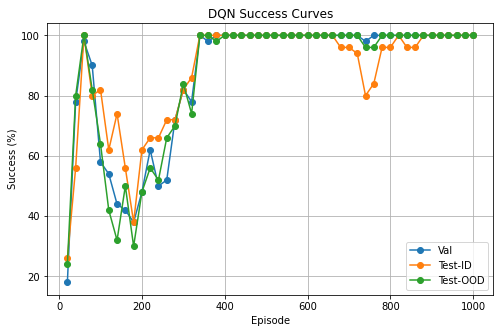

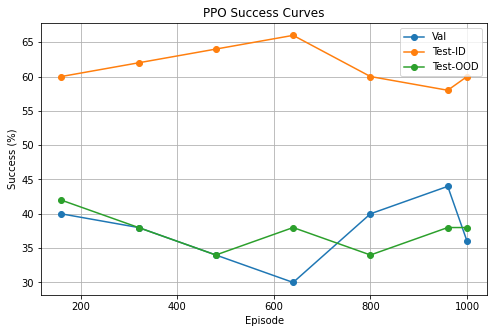

In [1]:
# ============================
# Part 1: Imports
# ============================
import os, random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from models import EEGNetHybridNorm   # <- 你已有的 SL 模型

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =", device)


# ============================
# Part 2: Original Environment
# ============================
class BCI2DCursorEnv(gym.Env):

    def __init__(self, eeg_segments, labels, sl_model_path,
                 feature_npz_path=None, method='hybrid', success_radius=2.0):
        super().__init__()

        self.eeg_segments = eeg_segments
        self.labels = labels
        self.num_segments = len(eeg_segments)
        self.segment_len = eeg_segments.shape[1]
        self.success_radius = float(success_radius)

        self.method = method
        self.grid_size = 20
        self.max_steps = 6

        # Load SL decoder
        self.sl_decoder = self._load_sl_decoder(sl_model_path)

        # feature_bank from .npz
        if feature_npz_path is not None:
            npz = np.load(feature_npz_path)

            if "features" in npz:
                self.feature_bank = npz["features"]
                print(f" Hybrid : feature_bank = {self.feature_bank.shape}")
            else:
                raise ValueError("npz 文件必须包含 'features' 键")
        else:
            self.feature_bank = None

        # Action
        self.action_space = spaces.Discrete(4)

        # Observation (Hybrid 168D)
        self.observation_space = spaces.Box(low=-10, high=10, shape=(168,), dtype=np.float32)

        self.current_segment_idx = None
        self.current_segment = None
        self.segment_labels = None
        self.trial_ptr = 0
        self.steps = 0
        self.cursor_pos = None
        self.target_pos = None
        self._last_distance = None

    def _load_sl_decoder(self, path):
        model = EEGNetHybridNorm(num_classes=4, num_channels=22, sample_length=1000)
        model.load_state_dict(torch.load(path, map_location="cpu"))
        model.eval()
        print(" SL :", path)
        return model

    def _get_sl_probabilities(self, eeg_signal):
        with torch.no_grad():
            eeg_tensor = torch.FloatTensor(eeg_signal).unsqueeze(0).unsqueeze(0)
            logits = self.sl_decoder(eeg_tensor)
            probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
        return probs.astype(np.float32)

    def _get_eeg_features(self):
        idx = self.current_segment_idx * self.segment_len + self.trial_ptr
        idx = min(idx, len(self.feature_bank)-1)
        feats = self.feature_bank[idx]
        return feats[:160].astype(np.float32)

    def _build_state(self, eeg_signal):
        eeg_feat = self._get_eeg_features()
        sl = self._get_sl_probabilities(eeg_signal)
        return np.concatenate([eeg_feat, sl, self.cursor_pos, self.target_pos], axis=0).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_segment_idx = np.random.randint(0, self.num_segments)
        self.current_segment = self.eeg_segments[self.current_segment_idx]
        self.segment_labels = self.labels[self.current_segment_idx]
        self.trial_ptr = 0
        self.steps = 0

        # Initialize position
        self.cursor_pos = np.array([10, 10], dtype=np.float32)
        target_offsets = {1: [-5, 0], 2: [5, 0], 3: [0, -5], 4: [0, 5]}
        offset = target_offsets[int(self.segment_labels[-1])]
        self.target_pos = np.clip(self.cursor_pos + offset, 0, self.grid_size-1)

        self._last_distance = np.linalg.norm(self.cursor_pos - self.target_pos)

        eeg_sig = self.current_segment[self.trial_ptr]
        return self._build_state(eeg_sig), {}

    def step(self, action):

        move_map = {
            0: np.array([0, 1]),
            1: np.array([0, -1]),
            2: np.array([-1, 0]),
            3: np.array([1, 0])
        }

        self.cursor_pos = np.clip(self.cursor_pos + move_map[action], 0, self.grid_size-1)
        self.steps += 1

        # reward
        dist = np.linalg.norm(self.cursor_pos - self.target_pos)
        reward = -1 + (self._last_distance - dist)*10
        done = False

        if dist < 0.1:
            reward += 100
            done = True

        self._last_distance = dist

        # next EEG
        self.trial_ptr += 1
        if self.trial_ptr < self.segment_len:
            eeg_sig = self.current_segment[self.trial_ptr]
            next_state = self._build_state(eeg_sig)
        else:
            done = True
            next_state = np.zeros(168, dtype=np.float32)

        if self.steps >= self.segment_len:
            done = True

        return next_state, reward, done, False, {}


# ============================
# Part 3: 160→8 projector + wrapper
# ============================
class ProjectionNet(nn.Module):
    def __init__(self, in_dim=160, out_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, out_dim),
        )

    def forward(self, x):
        return self.net(x)


def state_to16(raw_state, proj):
    eeg = raw_state[:160]
    sl = raw_state[160:164]
    cursor = raw_state[164:166]
    target = raw_state[166:168]

    with torch.no_grad():
        z8 = proj(torch.tensor(eeg, dtype=torch.float32, device=device).unsqueeze(0)).cpu().numpy()[0]

    return np.concatenate([z8, sl, cursor, target]).astype(np.float32)


class Hybrid16DEnvWrapper:
    def __init__(self, env, proj):
        self.env = env
        self.proj = proj
        self.action_space = env.action_space
        self.observation_space = spaces.Box(low=-5, high=5, shape=(16,), dtype=np.float32)
        self.success_radius = env.success_radius

    def reset(self):
        raw, info = self.env.reset()
        return state_to16(raw, self.proj), info

    def step(self, action):
        raw, reward, done, trunc, info = self.env.step(action)
        if not done:
            s = state_to16(raw, self.proj)
        else:
            s = np.zeros(16, dtype=np.float32)
        return s, reward, done, trunc, info


# ============================
# Part 4A: evaluate_success
# ============================
def evaluate_success(env, policy, episodes=50):
    success = 0
    for _ in range(episodes):

        state, _ = env.reset()
        done = False

        while not done:
            s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            with torch.no_grad():
                out = policy(s)
                if isinstance(out, tuple):   # PPO
                    pi = out[0]
                else:
                    pi = out

            a = int(torch.argmax(pi))
            ns, r, done, _, _ = env.step(a)
            state = ns

        if np.linalg.norm(env.env.cursor_pos - env.env.target_pos) < env.success_radius:
            success += 1

    return success / episodes * 100



# ============================
# Part 4B: DQN (你的 3DQN 改为16D输入)
# ============================
class DuelingQNet(nn.Module):
    def __init__(self, state_dim=16, action_dim=4, hidden=256):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU()
        )
        self.value = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.adv = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_dim)
        )

    def forward(self, x):
        h = self.feature(x)
        v = self.value(h)
        a = self.adv(h)
        return v + (a - a.mean(dim=1, keepdim=True))


class DQNBuffer:
    def __init__(self, cap=8000):
        from collections import deque
        self.buf = deque(maxlen=cap)

    def push(self,s,a,r,ns,d):
        self.buf.append((s,a,r,ns,d))

    def sample(self, bs):
        batch = random.sample(self.buf, bs)
        s,a,r,ns,d = zip(*batch)
        return (
            torch.tensor(np.array(s),dtype=torch.float32,device=device),
            torch.tensor(a,dtype=torch.long,device=device),
            torch.tensor(r,dtype=torch.float32,device=device),
            torch.tensor(np.array(ns),dtype=torch.float32,device=device),
            torch.tensor(d,dtype=torch.float32,device=device)
        )

    def __len__(self):
        return len(self.buf)



def train_dqn_with_checkpoints(train_env, val_env, test_id_env, test_ood_env,
                               num_episodes=1000,
                               gamma=0.9, lr=1e-4,
                               eps_start=1.0, eps_end=0.05, eps_decay=0.995,
                               batch_size=128,
                               ckpt_interval=20):

    # init
    s,_ = train_env.reset()
    q = DuelingQNet().to(device)
    tgt = DuelingQNet().to(device)
    tgt.load_state_dict(q.state_dict())

    opt = optim.Adam(q.parameters(), lr=lr)
    buf = DQNBuffer()

    eps = eps_start

    ckpts = []
    val_s, tid_s, tod_s = [], [], []

    for ep in range(1, num_episodes+1):

        s,_ = train_env.reset()
        done = False
        total_r = 0

        while not done:

            if random.random() < eps:
                a = train_env.action_space.sample()
            else:
                with torch.no_grad():
                    a = int(torch.argmax(q(torch.tensor(s,dtype=torch.float32,device=device).unsqueeze(0))))

            ns,r,done,_,_ = train_env.step(a)
            buf.push(s,a,r,ns,done)
            s = ns
            total_r += r

            if len(buf) > batch_size:
                sb,ab,rb,nsb,db = buf.sample(batch_size)

                with torch.no_grad():
                    na = q(nsb).argmax(1,keepdim=True)
                    nq = tgt(nsb).gather(1,na).squeeze()
                    target = rb + gamma*(1-db)*nq

                qv = q(sb).gather(1, ab.unsqueeze(1)).squeeze()
                loss = F.mse_loss(qv, target)

                opt.zero_grad()
                loss.backward()
                opt.step()

        eps = max(eps_end, eps*eps_decay)

        if ep % ckpt_interval == 0:
            ckpts.append(ep)

            v = evaluate_success(val_env, q)
            ti = evaluate_success(test_id_env, q)
            to = evaluate_success(test_ood_env, q)

            val_s.append(v)
            tid_s.append(ti)
            tod_s.append(to)

            print(f"[DQN Ep {ep}] VAL={v:.1f}% | Test-ID={ti:.1f}% | Test-OOD={to:.1f}%")

            tgt.load_state_dict(q.state_dict())

    return ckpts, val_s, tid_s, tod_s



# ============================
# Part 4C: PPO
# ============================
class PPOPolicy(nn.Module):
    def __init__(self, state_dim=16, action_dim=4):
        super().__init__()
        self.pi_body = nn.Sequential(
            nn.Linear(state_dim,128), nn.ReLU(),
            nn.Linear(128,128), nn.ReLU(),
        )
        self.pi_head = nn.Linear(128,action_dim)

        self.v_body = nn.Sequential(
            nn.Linear(state_dim,128), nn.ReLU(),
            nn.Linear(128,128), nn.ReLU(),
            nn.Linear(128,1)
        )

    def forward(self,x):
        h = self.pi_body(x)
        return F.softmax(self.pi_head(h),dim=1), self.v_body(x)


def train_ppo_with_checkpoints(train_env, val_env, test_id_env, test_ood_env,
                               num_episodes=1000, rollout_len=32,
                               gamma=0.99, lam=0.95,
                               lr=3e-4, clip_eps=0.2,
                               update_epochs=4,
                               batch_size=64,
                               ckpt_interval=10):

    policy = PPOPolicy().to(device)
    opt = optim.Adam(policy.parameters(), lr=lr)

    ckpts, val_s, tid_s, tod_s = [], [], [], []

    ep = 0
    while ep < num_episodes:

        states, actions, rewards, dones, logps_old, values = [], [], [], [], [], []

        for _ in range(rollout_len):
            s,_ = train_env.reset()
            done = False
            while not done:
                st = torch.tensor(s,dtype=torch.float32,device=device).unsqueeze(0)

                pi, v = policy(st)
                a = int(torch.multinomial(pi,1))
                logp = torch.log(pi[0,a]+1e-6)

                ns,r,done,_,_ = train_env.step(a)

                states.append(s)
                actions.append(a)
                rewards.append(r)
                dones.append(done)
                logps_old.append(logp.detach())
                values.append(v.detach())

                s = ns

                if done:
                    ep += 1
                    break
                if ep >= num_episodes:
                    break
            if ep>=num_episodes:
                break

        # ========== Compute advantage ==========
        values = torch.cat(values).squeeze()
        logps_old = torch.stack(logps_old)

        adv = []
        gae = 0
        values_np = values.cpu().numpy()
        for t in reversed(range(len(rewards))):
            next_v = values_np[t+1] if t+1<len(values_np) else 0
            delta = rewards[t] + gamma*next_v*(1-dones[t]) - values_np[t]
            gae = delta + gamma*lam*(1-dones[t])*gae
            adv.append(gae)
        adv.reverse()
        adv = torch.tensor(adv,dtype=torch.float32,device=device)
        returns = adv + values

        # ========== Update ==========
        states_t = torch.tensor(np.array(states),dtype=torch.float32,device=device)
        actions_t = torch.tensor(actions,dtype=torch.long,device=device)
        dataset_size = len(states)

        for _ in range(update_epochs):
            idx = np.random.permutation(dataset_size)
            for start in range(0,dataset_size,batch_size):
                batch_idx = idx[start:start+batch_size]

                st = states_t[batch_idx]
                at = actions_t[batch_idx]
                ret = returns[batch_idx]
                old_lp = logps_old[batch_idx]
                adv_b = adv[batch_idx]

                pi, v = policy(st)
                logp = torch.log(pi.gather(1,at.unsqueeze(1))+1e-6).squeeze()

                ratio = torch.exp(logp - old_lp)
                surr1 = ratio * adv_b
                surr2 = torch.clamp(ratio,1-clip_eps,1+clip_eps)*adv_b

                loss_pi = -torch.min(surr1,surr2).mean()
                loss_v = F.mse_loss(v.squeeze(), ret)

                loss = loss_pi + 0.5*loss_v

                opt.zero_grad()
                loss.backward()
                opt.step()

        if ep % ckpt_interval == 0:
            ckpts.append(ep)

            v = evaluate_success(val_env, policy)
            ti = evaluate_success(test_id_env, policy)
            to = evaluate_success(test_ood_env, policy)

            val_s.append(v)
            tid_s.append(ti)
            tod_s.append(to)

            print(f"[PPO Ep {ep}] VAL={v:.1f}% | Test-ID={ti:.1f}% | Test-OOD={to:.1f}%")

    return ckpts, val_s, tid_s, tod_s



# ============================
# Part 5: Plot functions
# ============================
def plot_three_curves(ck, val, tid, tod, title):
    plt.figure(figsize=(8,5))
    plt.plot(ck, val, label="Val", marker="o")
    plt.plot(ck, tid, label="Test-ID", marker="o")
    plt.plot(ck, tod, label="Test-OOD", marker="o")
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Success (%)")
    plt.show()



# ============================
# Part 6: Build env
# ============================
print("=== Loading datasets ===")
train_data = np.load("data_sequences/test_id_5subj_segments.pkl", allow_pickle=True)
val_data   = np.load("data_sequences/val_ood_2subj_segments.pkl", allow_pickle=True)
test_id_data  = np.load("data_sequences/test_id_5subj_segments.pkl", allow_pickle=True)
test_ood_data = np.load("data_sequences/test_ood_2subj_segments.pkl", allow_pickle=True)

# raw envs
raw_train_env = BCI2DCursorEnv(train_data["segments"], train_data["labels"],
                               "models/pooled_eegnet_best.pth",
                               "features_SL/test_id.npz")

raw_val_env = BCI2DCursorEnv(val_data["segments"], val_data["labels"],
                             "models/pooled_eegnet_best.pth",
                             "features_SL/val_ood.npz")

raw_test_id_env = BCI2DCursorEnv(test_id_data["segments"], test_id_data["labels"],
                                  "models/pooled_eegnet_best.pth",
                                  "features_SL/test_id.npz")

raw_test_ood_env = BCI2DCursorEnv(test_ood_data["segments"], test_ood_data["labels"],
                                   "models/pooled_eegnet_best.pth",
                                   "features_SL/test_ood.npz")


# 160→8 compressor
proj = ProjectionNet().to(device)

# wrap to 16D
train_env = Hybrid16DEnvWrapper(raw_train_env, proj)
val_env   = Hybrid16DEnvWrapper(raw_val_env, proj)
test_id_env = Hybrid16DEnvWrapper(raw_test_id_env, proj)
test_ood_env = Hybrid16DEnvWrapper(raw_test_ood_env, proj)

print("=== Env Build Completed (16D) ===")


# ============================
# Part 7: Train DQN + PPO
# ============================
print("===== Training DQN =====")
ck_dqn, val_dqn, tid_dqn, tod_dqn = train_dqn_with_checkpoints(
    train_env, val_env, test_id_env, test_ood_env
)

print("===== Training PPO =====")
ck_ppo, val_ppo, tid_ppo, tod_ppo = train_ppo_with_checkpoints(
    train_env, val_env, test_id_env, test_ood_env
)


# ============================
# Part 8: Print all success rates
# ============================
print("\n=== Final Success Rates ===")
print("DQN:")
print("Val     :", val_dqn)
print("Test-ID :", tid_dqn)
print("Test-OOD:", tod_dqn)

print("\nPPO:")
print("Val     :", val_ppo)
print("Test-ID :", tid_ppo)
print("Test-OOD:", tod_ppo)


# ============================
# Part 9: Plot curves
# ============================
plot_three_curves(ck_dqn, val_dqn, tid_dqn, tod_dqn, "DQN Success Curves")

plot_three_curves(ck_ppo, val_ppo, tid_ppo, tod_ppo, "PPO Success Curves")

